In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.regularizers import l2


In [13]:
df = pd.read_csv("retail_store_inventory.csv")
df["Date"] = pd.to_datetime(df["Date"], errors='coerce') #handle datatype 

In [14]:
store1=df[df["Store ID"]=="S001"]
store2=df[df["Store ID"]=="S002"]
store3=df[df["Store ID"]=="S003"]
store4=df[df["Store ID"]=="S004"]
store5=df[df["Store ID"]=="S005"]

data=store1 # 1. store 

In [30]:
sp1 = data.groupby(['Date','Product ID']).sum()
sp1_filtered = sp1.loc[sp1.index.get_level_values('Product ID') == 'P0001']
sp1_filtered_reset = sp1_filtered.reset_index(level='Product ID', drop=True)
unit = sp1_filtered_reset[['Units Sold']]

In [31]:
unit.reset_index()

,Date,Units Sold
0,2022-01-01,127
1,2022-01-02,81
2,2022-01-03,5
3,2022-01-04,58
4,2022-01-05,147
...,...,...
726,2023-12-28,67
727,2023-12-29,168
728,2023-12-30,30
729,2023-12-31,26


In [32]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(unit)

# Convert to DataFrame
scaled_data = pd.DataFrame(scaled_data, index=unit.index, columns=["Units Sold"])


In [33]:
scaled_data

,Units Sold
Date,
2022-01-01,0.275488
2022-01-02,0.175705
2022-01-03,0.010846
2022-01-04,0.125813
2022-01-05,0.318872
...,...
2023-12-28,0.145336
2023-12-29,0.364425
2023-12-30,0.065076


In [19]:
def create_sequences(data, seq_length=30):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 1
X, y = create_sequences(scaled_data.values, seq_length)
# X, y = create_sequences(unit.values, seq_length)

# Split into train and test sets
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Reshape for LSTM input (samples, time steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


In [26]:
# Build LSTM model
model = Sequential([
    LSTM(12, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.1),
    LSTM(8, return_sequences=False, activation="relu"),
    Dropout(0.2),
    Dense(1)
])

# Compile model
model.compile(optimizer='adam', loss='mse')

# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=30, validation_data=(X_test, y_test), verbose=0, shuffle=False)


In [21]:
# model = Sequential([
#     Bidirectional(LSTM(10, return_sequences=True), input_shape=(seq_length, 1)),
#     Dropout(0.2),
#     Bidirectional(LSTM(8)),
#     Dropout(0.2),
#     Dense(1, activation='linear', kernel_regularizer=l2(0.01))
# ])

# # Compile model
# model.compile(optimizer='adam', loss='mse')

# # Train model
# history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), verbose=2)

5/5 [==============================] - 0s 12ms/step


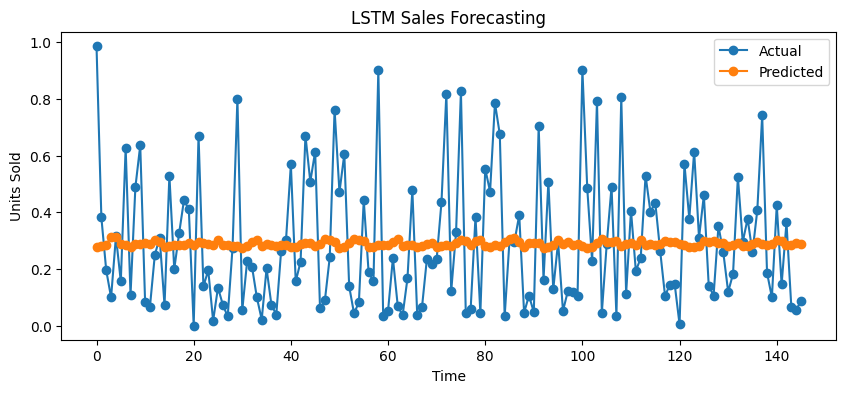

In [27]:
# Make predictions
y_pred = model.predict(X_test)

# Inverse transform predictions
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

# Plot actual vs predicted
plt.figure(figsize=(10,4))
plt.plot(y_test, label="Actual", marker='o')
plt.plot(y_pred, label="Predicted", marker='o')
plt.xlabel("Time")
plt.ylabel("Units Sold")
plt.title("LSTM Sales Forecasting")
plt.legend()
plt.show()
